#### Credit: 
Kim Gerdes, Kirian Guiller

In [1]:
## constants, for later
WINDOW_SIZE = 3
VOCAB_SIZE = 5000
MEMORY_LIMIT = 10000
EMBED_DIM = 100

# A dive into embeddings

## Outline:

### Part 1. Data extraction, cleaning, tokenization, building a train set (skip gram)

### Part 2. Learning word2vec in pure numpy

### Part 3. Studying the result (learned embedding)

Preliminary steps:
- tokenization (very simple example)
- token-words vs token-indices 
- initialization
- visualization
- forward, cost function, backward, training
- first on a single sentence, then on a bigger text

Main goal: understand the successive transformations which allow to get a decent vectorial representation of words.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os, time
## handy files-loading-management: glob
from glob import glob
# re as Regular Expression
import re
import json

## Counter: counting occurences easily (lazy method)
from collections import Counter

In [85]:
import torch
import torch.nn as nn


# Part 1. Data extraction, cleaning, tokenization, building a train set (skip gram)

We perform the following steps, first on a short sentence:
- tokenization
- converting to indices (almost a one-hot vector)
- generate training data (skip gram style)
- Same operations but for an actual corpus


## 1.1 Tokenization 
We convert a single sentence into tokens, i.e. words or equivalent, essentially

In [6]:
## simple tokenization:
phrase = "Il m’a bien ennervée, ce gars-là, avec ce copier-coller !"
retoken = re.compile(r"\w+")
retoken.findall(phrase.lower().replace('’',"'"))

['il',
 'm',
 'a',
 'bien',
 'ennervée',
 'ce',
 'gars',
 'là',
 'avec',
 'ce',
 'copier',
 'coller']

In [7]:
## more advanced tokenization...
phrase = "Il m'a bien ennervée, ce gars-là, avec ce copier-coller !"
retoken = re.compile(r"\w+'?")
# the simpler is to first replace:
reclitic = re.compile(r"-(là|ci|je|tu|il|elle|t-il|t-elle|ils|elles|t-ils|t-elles|nous|vous)")
phrase = reclitic.sub(r' \1',phrase)
retoken = re.compile(r"[\w-]+'?")
retoken.findall(phrase.lower())

['il',
 "m'",
 'a',
 'bien',
 'ennervée',
 'ce',
 'gars',
 'là',
 'avec',
 'ce',
 'copier-coller']

In [8]:
def tokenize(phrase):
    retoken = re.compile(r"\w+'?")
    retoken = re.compile(r"[\w-]+'?")
    return retoken.findall(reclitic.sub(r' \1',phrase.lower()).replace('’',"'").replace('',"'")) 
    # problèmes d'encodage de certains fichiers : dEDF

In [24]:
tokens = tokenize(phrase)
tokens

['il',
 "m'",
 'a',
 'bien',
 'ennervée',
 'ce',
 'gars',
 'là',
 'avec',
 'ce',
 'copier-coller']

## 1.2 Converting to indices (almost a one-hot vector)

(and storing the mapping of course)

In [39]:
Counter(tokens).most_common()

[('ce', 2),
 ('il', 1),
 ("m'", 1),
 ('a', 1),
 ('bien', 1),
 ('ennervée', 1),
 ('gars', 1),
 ('là', 1),
 ('avec', 1),
 ('copier-coller', 1)]

In [46]:
def mapping(tokens):
    """
    tokens : list of tokens
    tok2id : dictionnary : link between tokens (in letters) and token-index
    id2tok : dictionnary:  inverse of tok2id
    fin todo
    """
    tok2id = dict()
    id2tok = dict()

    unique_token = np.unique(tokens)
    for i,token in enumerate(unique_token):
        tok2id[token] = i
        id2tok[i]     = token

    return tok2id, id2tok

In [47]:
tok2id, id2tok = mapping(tokens)
tok2id, id2tok

({'a': 0,
  'avec': 1,
  'bien': 2,
  'ce': 3,
  'copier-coller': 4,
  'ennervée': 5,
  'gars': 6,
  'il': 7,
  'là': 8,
  "m'": 9},
 {0: 'a',
  1: 'avec',
  2: 'bien',
  3: 'ce',
  4: 'copier-coller',
  5: 'ennervée',
  6: 'gars',
  7: 'il',
  8: 'là',
  9: "m'"})

## 1.3 Create training data (skip-gram style)

In [48]:
def generate_training_data(tokens, tok2id, window_size):
    """
    we create pairs of X,Y for training:
    X and Y have same length: 
    X is the index of the input token,
    Y is the one-hot (several-hot actually) encoding of the context tokens (output)
    """
    vocabulary = tok2id.keys()
    X = []
    Y = []
    N = len(tokens)
    if N >= 2*window_size+1:
        ## replace unknown words with <unk>
        for i, tok in enumerate(tokens):
            if tok not in vocabulary:
                tokens[i] = "<unk>"

        for i in range(window_size, N-window_size-1):
            window = tokens[i-window_size:i+window_size+1]

            x = []
            for tok in window:
                x.append(tok2id[tok])
            
            y = np.zeros((2*window_size+1)*len(vocabulary))
            for i,id in enumerate(x):
                y[(2*window_size+1)*i + id] = 1
            
            X.append(x)
            Y.append(y)
            
    return X, Y

In [49]:
tokens

['il',
 "m'",
 'a',
 'bien',
 'ennervée',
 'ce',
 'gars',
 'là',
 'avec',
 'ce',
 'copier-coller']

#### Let's check on the first example:

In [50]:
window_size = 3
X, Y = generate_training_data(tokens, tok2id, window_size)
X, Y

([[7, 9, 0, 2, 5, 3, 6],
  [9, 0, 2, 5, 3, 6, 8],
  [0, 2, 5, 3, 6, 8, 1],
  [2, 5, 3, 6, 8, 1, 3]],
 [array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0

In [51]:
phrase

"Il m'a bien ennervée, ce gars là, avec ce copier-coller !"

In [52]:
id2tok[4], id2tok[5], id2tok[0], id2tok[6]

('copier-coller', 'ennervée', 'a', 'gars')

In [53]:
id2tok[0], id2tok[1], id2tok[2], id2tok[3], id2tok[5], id2tok[6]

('a', 'avec', 'bien', 'ce', 'ennervée', 'gars')

In [54]:
Y[0][:15]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.])

## 2.4 Same operations but now for an actual corpus

- First, we need to look at word frequencies, and decide a cut-off: words (types) more frequent than this cutoff will be part of the vocabulary, less frequent types will be replaced with the tyoe "<unk>" (unknown)
- Then, we open again all files and encode their sentences into one-hot vectors.

###  (1)  Data Loading, tokenization, counting types frequencies

# WARNING : of course, unzip "Plain text" and put it in the right place...

In [62]:
textfiles = [y for x in os.walk('.') for y in glob(os.path.join(x[0], '*.txt'))]
print('We have ',len(textfiles),' text files.')

We have  1  text files.


In [63]:
def tokenize(phrase):
#     retoken = re.compile(r"\w+'?")
    retoken = re.compile(r"[\w-]+'?")
    reclitic = re.compile(r"-(là|ci|je|tu|il|elle|t-il|t-elle|ils|elles|t-ils|t-elles|nous|vous)")
    return retoken.findall(reclitic.sub(r' \1',phrase.lower()).replace('’',"'").replace('',"'")) 
    # problèmes d'encodage de certains fichiers : dEDF

In [64]:
# this Counter helps us count types occurences in a few lines:
wordcounter = Counter()
for f in textfiles:
    tokenized_text = tokenize(open(f, encoding='iso-8859-15').read())
    wordcounter.update(Counter(tokenized_text))

In [65]:
wordcounter["equipe"], wordcounter

(1,
 Counter({'-0': 2604020,
          '0': 2288419,
          '-1': 57232,
          '1': 49231,
          'dã': 1187,
          '0065': 1114,
          '0209': 1114,
          '0071': 1104,
          'e': 1104,
          '0189': 1103,
          '0033': 1099,
          '0161': 1099,
          '0140': 1099,
          '0068': 1095,
          '0163': 1093,
          '0248': 1092,
          '0270': 1090,
          '0055': 1089,
          '0172': 1088,
          '0001': 1087,
          '0393': 1086,
          '0443': 1085,
          '0205': 1085,
          '0186': 1085,
          '0041': 1083,
          '0002': 1082,
          '0249': 1081,
          '0432': 1079,
          '0371': 1079,
          '0301': 1078,
          '0208': 1077,
          '0054': 1077,
          '0044': 1077,
          '0022': 1075,
          '0007': 1075,
          '0101': 1074,
          '0449': 1074,
          '0830': 1074,
          '0089': 1073,
          '0232': 1073,
          '0074': 1072,
          '0606': 1

In [66]:
print('Nous avons',len(wordcounter),'types et', sum(wordcounter.values()),'tokens.')
print('Voici les 10 mots les plus courants :', wordcounter.most_common(10))

Nous avons 53906 types et 10060685 tokens.
Voici les 10 mots les plus courants : [('-0', 2604020), ('0', 2288419), ('-1', 57232), ('1', 49231), ('dã', 1187), ('0065', 1114), ('0209', 1114), ('0071', 1104), ('e', 1104), ('0189', 1103)]


### (2) Ordering types by their frequency, definition of the vocabulary

In [67]:
# VOCAB_SIZE = 5000

## NOTE !!! IT IS VERY IMPORTANT TO ORDER THEM BY FEQUENCY, HERE !!! 
common_words_list_of_pairs = wordcounter.most_common(VOCAB_SIZE)  # sorts types by their frequency of occurence
common_words_list_of_pairs[:7]

[('-0', 2604020),
 ('0', 2288419),
 ('-1', 57232),
 ('1', 49231),
 ('dã', 1187),
 ('0065', 1114),
 ('0209', 1114)]

<Axes: >

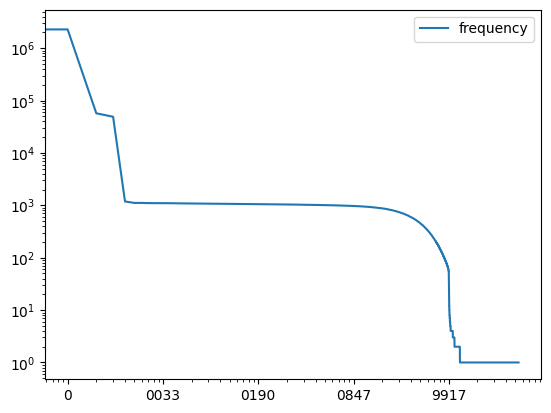

In [68]:
freq_df = pd.DataFrame.from_dict(wordcounter, orient='index', columns=['frequency']).sort_values(by='frequency', ascending=False)
freq_df.plot(loglog=True)

### (3) Converting to indices (almost a one-hot vector)

In [69]:
## create a dictionnary from token to id (arbitrary ID)
## and one from ID to token (useful for inference on other texts too !)
tok2id = {}
id2tok = {}
other_words_token = "<unk>"  # special token to describe all other words (not in the vocab)

i=0
token = other_words_token
tok2id[token] = i
id2tok[i] = token
i+=1
for element in common_words_list_of_pairs:  ## it's crucial that we ordered types by frequency !!
    token, freq = element
    tok2id[token] = i
    id2tok[i] = token
    i+=1

In [70]:
common_words_list_of_pairs[-1]

('4614', 459)

In [71]:
wordcounter[common_words_list_of_pairs[-1][0]]

459

In [72]:
# tok2id

In [73]:
# id2tok

In [74]:
## we save our dicts for later use
myjson = json.dumps(tok2id)
f = open("tok2id.json","w")
f.write(myjson)
f.close()
myjson = json.dumps(id2tok)
f = open("id2tok.json","w")
f.write(myjson)
f.close()

In [75]:
vocabulary = tok2id.keys()
# vocabulary

### [optionnal] Quick study of the relationship between type length and frequency of that type:

In [76]:
print('longueur moyenne dans le dictionnaire (sur les types) :',sum([len(t) for t in wordcounter])/len(wordcounter))
print('longueur moyenne dans le texte (sur les tokens) :',sum([len(t)*f for t,f in wordcounter.items()])/ sum(wordcounter.values()))
print('les mots les plus longs :', sorted(wordcounter, key=lambda x:len(x), reverse=True)[:10])

longueur moyenne dans le dictionnaire (sur les types) : 6.546265721812043
longueur moyenne dans le texte (sur les tokens) : 2.7862160479132383
les mots les plus longs : ['unterseebootsflottille', 'professionnalisation', 'socioprofessionnelle', 'intergouvernementale', 'proportionnellement', 'perpendiculairement', 'professionnellement', 'pluridisciplinaires', 'interdisciplinaires', 'administrativement']


In [77]:
lenfreq = {} # contiendra longueur du mot vers la fréquence dans le dictionnaire
for t,f in wordcounter.items():
    lenfreq[len(t)] = lenfreq.get(len(t),0)+1 # si remplace +1 par +f, on a la relation longueur / fréquence dans les textes
print(lenfreq)

{2: 715, 4: 13457, 1: 51, 3: 2711, 5: 5461, 6: 6571, 7: 6835, 9: 4488, 8: 5742, 10: 3215, 13: 696, 11: 2033, 12: 1287, 14: 344, 17: 31, 15: 184, 18: 18, 16: 58, 19: 5, 20: 3, 22: 1}


In [78]:
freq_df = pd.DataFrame.from_dict(lenfreq, orient='index', columns=['frequency']).sort_values(by='frequency', ascending=False)
freq_df.head()

,frequency
4,13457
7,6835
6,6571
8,5742
5,5461


<Axes: title={'center': 'notons la long tail!'}>

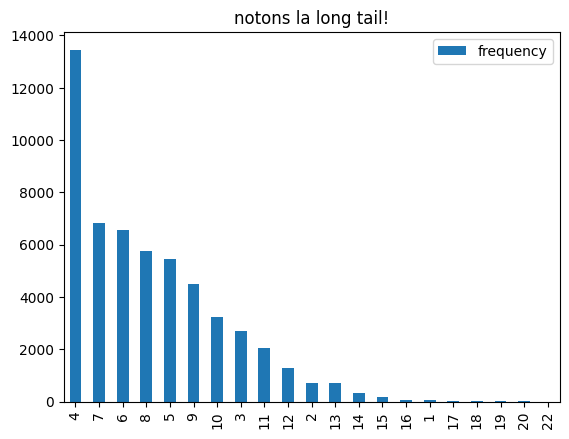

In [79]:
freq_df.plot(kind='bar', title='notons la long tail!')

### (4) Create training data (skip-gram style)

In [80]:
# we limit Y to be MEMORY_LIMIT x VOCAB_SIZE at most, otherwise we may lack memory
# MEMORY_LIMIT = 20000

### ROOM FOR IMPROVEMENT:

**(maybe next year I'll do it, don't try it now, I'd say)**

better than this generation of Y as a hard-coded numpy array (torch tensor), use this function at batch loading time: i.e., at every iteration of processing a batch, load some text files and convert them in that way.. 

Concretly, we should write a proper DataLoader (torch object) that does this. 

It's not a problem if all batches do not have exactly the same size

## But today we do it dirty-style (hard-coded, all-in-memory-style)

So, choose the variable `MEMORY_LIMIT` carefully, depending on how much RAM you have.

In [81]:
# WINDOW_SIZE =3
window_size=WINDOW_SIZE
X = []
Y = []
filenumber = -1
for f in textfiles:
    filenumber+=1
    with open(f, encoding='iso-8859-15') as f:
        texte = f.read()
        phrases = texte.split(".")
        for phrase in phrases:
            tokens = tokenize(phrase)
            N = len(tokens)
            if N >= 2*window_size+1:
                ## replace unknown words with <unk>
                for i, tok in enumerate(tokens):
                    if tok not in vocabulary:
                        tokens[i] = "<unk>"

                ## fill in X and Y:
                for i in range(window_size,N-window_size-1):
                    X.append(tok2id[tokens[i]]) ## input
                    ys = np.zeros(VOCAB_SIZE+1)
                    for j in range(i-window_size, i+window_size+1):
                        if i!=j: #  and 0<=j<N:
                            ys[tok2id[tokens[j]]] += 1
                    Y.append(ys)  ## context (to be predicted)
    if len(Y) > MEMORY_LIMIT:
        print(filenumber)
        break
       

In [86]:
X = np.array(X)
X = torch.tensor(X)
Y = torch.tensor(np.array(Y)) 

In [87]:
X.dtype

torch.float64

In [88]:
X.shape, Y.shape

(torch.Size([0]), torch.Size([0]))

### About the difference between nn.Embedding vs nn.Linear: 

https://stackoverflow.com/questions/65445174/what-is-the-difference-between-an-embedding-layer-with-a-bias-immediately-afterw

In this model, you should use:
- a layer with `nn.Embedding`
- a layer with nn.Linear (bias is useless)
- no activation function is needed
- even the softmax is implicit, it's hidden in the Loss (BCELoss)

In [89]:
import torch.nn as nn
class SkipGram_Model(nn.Module):
    """
    Implementation of Skip-Gram model described in paper:
    https://arxiv.org/abs/1301.3781
    """
    def __init__(self, vocab_size, embed_dim):
        super(SkipGram_Model, self).__init__()
        ## TODO
        
        pass
        
    def forward(self, inputs):
        ## TODO
        return ??
    

SyntaxError: invalid syntax (2069594129.py, line 15)

In [ ]:
def train(num_epochs, batch_size, criterion, optimizer, model, trainset):

    X, Y = trainset
    N = X.shape[0]
    N -= X.shape[0]%batch_size
    batch_number = X.shape[0]//batch_size    
    
    t0 = time.time()
    
    model.train() ## tells pytorch we are in train mode, not in test mode.
    running_losses=[]
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
    
        ## TODO: using batch size or just X,Y entirely, train the model
        
    t1 =time.time()
    print('Finished Training. It took '+str(t1-t0)+" seconds")
    return running_losses


In [ ]:
vocab_size = VOCAB_SIZE+1
embed_dim = EMBED_DIM
myOwnWord2Vec_model = SkipGram_Model(vocab_size=vocab_size, embed_dim=embed_dim)
trainset = (X, Y)

learning_rate=??
num_epochs=3
batch_size=??

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(myOwnWord2Vec_model.parameters(), lr=learning_rate)

In [ ]:
running_losses = train(num_epochs, batch_size, criterion, optimizer, myOwnWord2Vec_model, trainset)

In [ ]:
torch.save(myOwnWord2Vec_model.state_dict, "myOwnWord2Vec_model.torch.model_V="+str(vocab_size)+"_d="+str(embed_dim))
# vocab_size = VOCAB_SIZE+1
# embed_dim = 100

## Trying analogies... with small corpus, short training and small vocabulary...

... It doesn't work very well

In [ ]:
def token_to_vect(token):
    vector = myOwnWord2Vec_model.embeddings(torch.tensor([tok2id[token]]))
    vector_norm = np.linalg.norm(vector.detach())
    return vector/vector_norm

In [ ]:
all_words = torch.tensor(np.arange((VOCAB_SIZE+1), dtype=int))
all_vectors = np.array(myOwnWord2Vec_model.embeddings(all_words) .detach())
normes = np.linalg.norm(all_vectors, axis=1).reshape(-1,1)
all_vectors = all_vectors / normes


In [ ]:
vecteur_cible = token_to_vect("roi")+token_to_vect("femme")-token_to_vect("homme")
vecteur_cible = np.array(vecteur_cible.detach())
dot_prod = (all_vectors @ vecteur_cible.T)# / np.linalg.norm(vector.detach())
inds = dot_prod[:,0].argsort()
[id2tok[ind] for ind in np.array(inds)[::-1][:10]]

## TODOs: (for later, not today !)
- make a DataLoader to use the whole corpus even on a small machine
- learn with proper scheduler and for long enough ;)
- save the model
- load the model

## To understand how things work: quick debug out of the loop !

You can check for instance that your loss computes whay you want, here

In [ ]:
# vocab_size = VOCAB_SIZE+1
# embed_dim = 100
# myOwnWord2Vec_model = SkipGram_Model(vocab_size=vocab_size, embed_dim=embed_dim) ## only 1 layer !!

# learning_rate=3e-4
# num_epochs=10
# batch_size=128
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(myOwnWord2Vec_model.parameters(), lr=learning_rate)
# trainset = (X, Y)

In [ ]:
# ## we try 1 epoch, just to check things are ok:
# model = myOwnWord2Vec_model

# optimizer.zero_grad()
# y = model(X)

# ## backward pass
# loss = criterion(y, Y)  ## loss is also a torch object, so it also has the comput. graph.
# loss.backward() # computes and stores the gradients next to the tensors of parameters themselves.
# # at this point, the object 'model' has the gradients in it at the correct value.

# ## update of gradients
# optimizer.step() # updates the parameters wrt the local gradient
# ## recall that we defined:  optimizer = optim.SGD(model.parameters(), ... so it knows about the parameters.

In [ ]:
# loss

In [ ]:
# ## we can compute the loss "by hand" to check it's what we expect 
# ## with all the pytorch things happening inside BCELoss, we can't be too sure...
# softmax = nn.Softmax(dim=1)
# softy = np.array(softmax(y.detach()))
# softy.shape, softy.sum(1), softy.sum(1).shape

In [ ]:
# ## it does match :D
# np.sum(np.array(Y)*np.log(softy))/X.shape[0]

In [ ]:
# N  = X.shape[0]
# batch_number = X.shape[0]//batch_size
# X.shape[0]%batch_size
